In [2]:
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

In [3]:
# Import
import os
from dataloader import BatchDataloader
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
from torch.utils.data import TensorDataset, random_split, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score
from utils import pgd_attack, train_loop, eval_loop, train_loop_apgd
import utils
import ecg_plot
from models import ResNet1d, ResNet1dGELU
import ast
%matplotlib inline

In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

Use device: cuda



(12, 5000)


<Figure size 640x480 with 0 Axes>

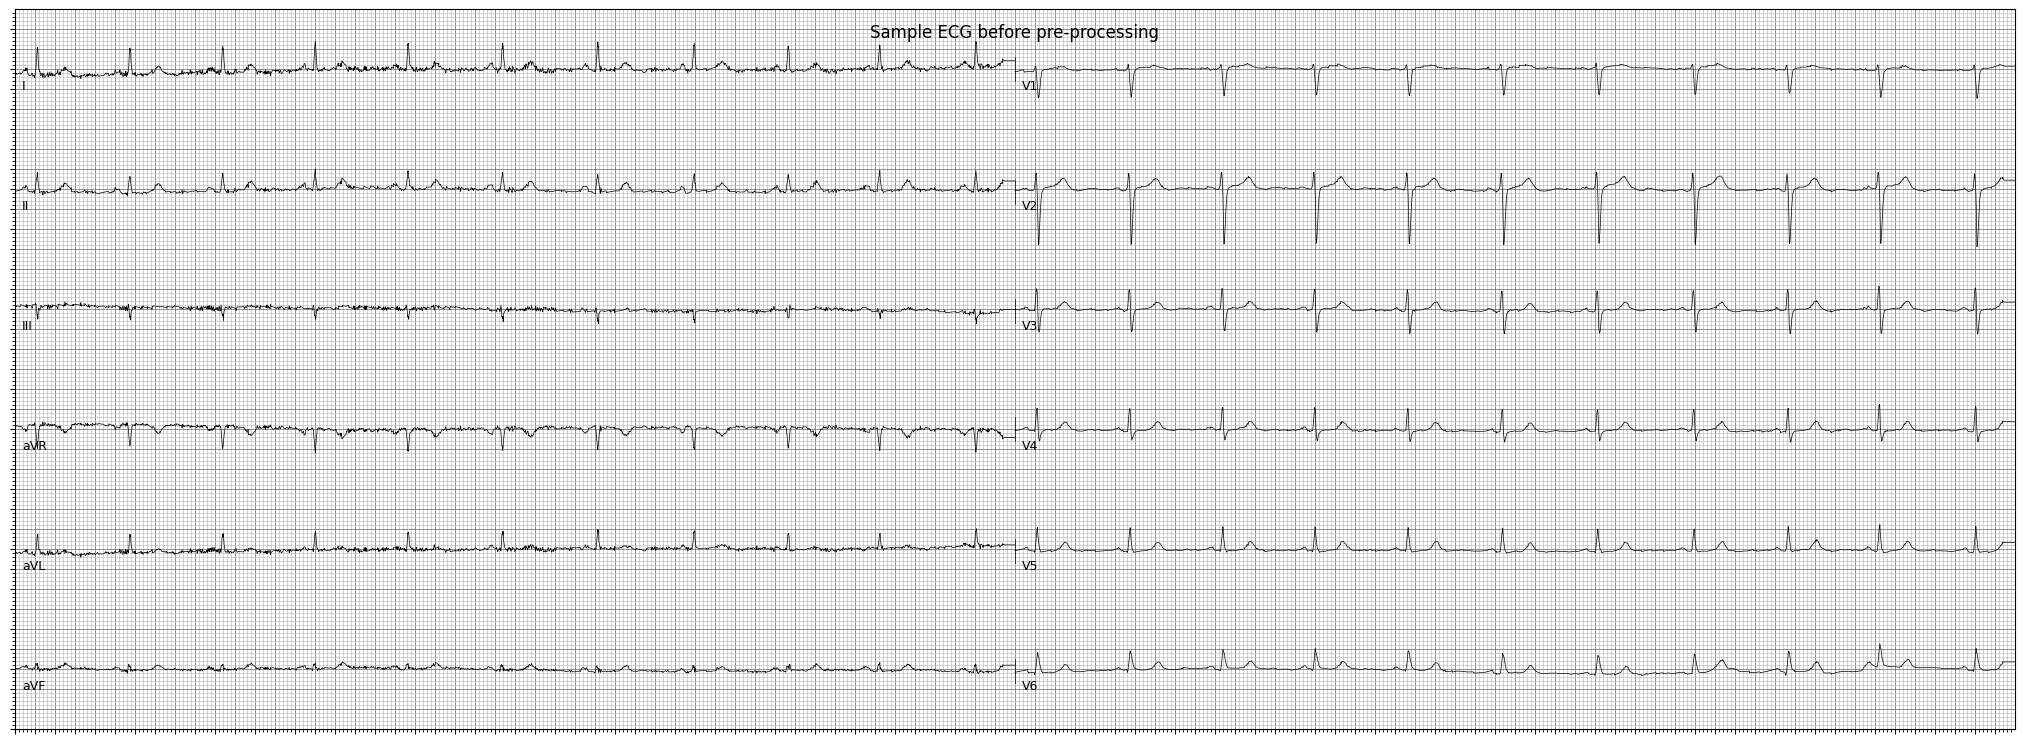

In [4]:
runfile("ecg-preprocessing/ecgprep/read_ecg.py")

PATH_TO_WFDB = 'ptb-xl/records500/00000/00001_hr'
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)

print(ecg_sample.shape)

# ECG plot
plt.figure()
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=6, columns=2, title='Sample ECG before pre-processing')
plt.show()

Namespace(path='ptb-xl/records500/00000/00001_hr', save='', new_freq=400.0, new_len=4096, scale=1, use_all_leads=True, remove_baseline=True, remove_powerline=60.0, fmt='wfdb')


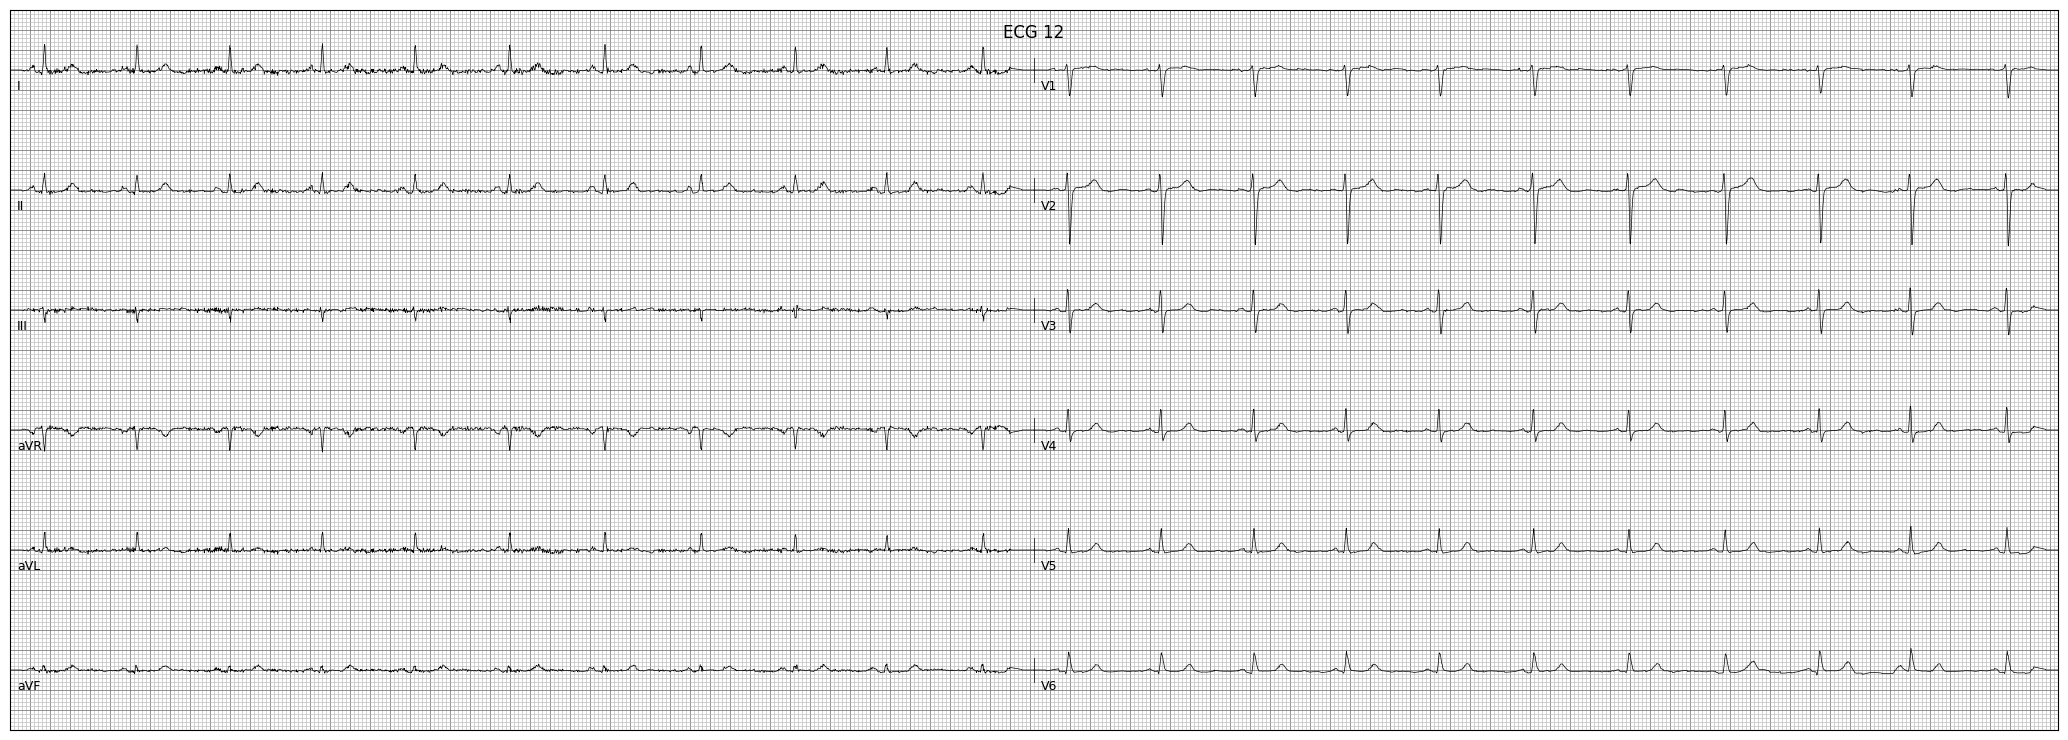

<Figure size 640x480 with 0 Axes>

In [5]:

%run ecg-preprocessing/plot_from_ecg.py ptb-xl/records500/00000/00001_hr --new_freq 400 --new_len 4096 --use_all_leads --remove_baseline --remove_powerline 60

In [6]:
# 3. Generate train
if not exists('ptb-xl/data.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --use_all_leads --remove_powerline 60 ptb-xl/RECORDS ptb-xl/data.h5
# 3. Generate test
#if not exists('codesubset/test.h5'):
#    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --remove_powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

ptb-xl/data.h5 already exits. Using cached. Delete it manually to recieve it again!


<Figure size 640x480 with 0 Axes>

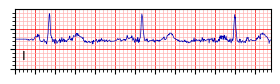

In [7]:
import h5py

PATH_TO_H5_FILE = 'ptb-xl/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']

ecg_sample = np.transpose(data[0])

# Take the first lead only, but preserve the shape
ecg_sample = ecg_sample[0, :1024]
ecg_sample = np.expand_dims(ecg_sample, axis=0)

plt.figure()
#lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=400, row_height=3, columns=1, title='')
# keep the ticks but remove the numbers on the x-axis
plt.show()

# plt.figure()
# ecg_plot.plot_1(ecg_sample, sample_rate=400, title='Sample ECG after pre-processing')
# plt.show()


In [5]:
batch_size = 32

In [7]:
# Load the data
path_to_csv, path_to_records, path_to_scp = '../ptb-xl/ptbxl_database.csv', '../ptb-xl/RECORDS', '../ptb-xl/scp_statements.csv'
path_to_train, path_to_val, path_to_test = '../ptb-xl/val.h5', '../ptb-xl/train.h5', '../ptb-xl/test.h5' # CHANGED TRAIN AND VAL FOR FINETUNING

# Get labels
df = pd.read_csv(path_to_csv, index_col='ecg_id')
df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path_to_scp, index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def has_key(dic, key_str):
    for key in dic.keys():
        if key == key_str:
            return 1
    return 0

# Apply diagnostic superclass
df['AF'] = df.scp_codes.apply(lambda x: has_key(x, 'AFIB'))

validation_fold = 9 # CHANGED TRAIN AND VAL FOR FINETUNING
test_fold = 10

# Load labels
val = df[(df.strat_fold != validation_fold) & (df.strat_fold != test_fold)]
train = df[df.strat_fold == validation_fold]
test = df[df.strat_fold == test_fold]

labels_train = train['sex'].values
labels_val = val['sex'].values
labels_test = test['sex'].values

# Print how many there are of each label in train
print(f'Number of AF in train: {np.sum(labels_train)}')
print(f'Number of normal in train: {len(labels_train) - np.sum(labels_train)}')

# Print how many there are of each label in val
print(f'Number of AF in val: {np.sum(labels_val)}')
print(f'Number of normal in val: {len(labels_val) - np.sum(labels_val)}')

# Print how many there are of each label in test
print(f'Number of AF in test: {np.sum(labels_test)}')
print(f'Number of normal in test: {len(labels_test) - np.sum(labels_test)}')

# Print total number of AF across all sets
print(f'Total number of AF: {np.sum(labels_train) + np.sum(labels_val) + np.sum(labels_test)}')
print(f'Total number of normal: {len(labels_train) + len(labels_val) + len(labels_test) - np.sum(labels_train) - np.sum(labels_val) - np.sum(labels_test)}')

# Make them torch tensors
labels_train = torch.tensor(labels_train, dtype=torch.float32).reshape(-1,1)
labels_val = torch.tensor(labels_val, dtype=torch.float32).reshape(-1,1)
labels_test = torch.tensor(labels_test, dtype=torch.float32).reshape(-1,1)

# Define traces
traces_train = h5py.File(path_to_train, 'r')['tracings']
traces_val = h5py.File(path_to_val, 'r')['tracings']
traces_test = h5py.File(path_to_test, 'r')['tracings']

# Define dataloaders
train_dataloader = BatchDataloader(traces_train, labels_train, batch_size=batch_size)
val_dataloader = BatchDataloader(traces_val, labels_val, batch_size=batch_size)
test_dataloader = BatchDataloader(traces_test, labels_test, batch_size=batch_size)

# df[df.strat_fold != validation_fold and df.strat_fold != test_fold]['filename_hr']

# Load traces
# traces_train = h5py.File(path_to_h5, 'r')['tracings'][()]
# traces_train = traces_train[labels_train.index]
# labels_train = labels_train.AF.values

# labels_train = torch.tensor(labels_train, dtype=torch.float32).reshape(-1,1)
# traces_train = torch.tensor(traces_train, dtype=torch.float32)
# dataset_train = TensorDataset(traces_train, labels_train)

# load labels
# sorting should not be needed as traces and csv are already in the same order
# ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces



Number of AF in train: 1050
Number of normal in train: 1133
Number of AF in val: 8329
Number of normal in val: 9089
Number of AF in test: 1066
Number of normal in test: 1132
Total number of AF: 10445
Total number of normal: 11354


In [24]:
# traces, diagnoses = next(iter(train_dataloader))

# ecg_sample = np.transpose(traces[0])

# plt.figure()
# #lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'I-adv', 'II-adv', 'V1-adv', 'V2-adv', 'V3-adv', 'V4-adv', 'V5-adv', 'V6-adv']
# lead = ['I', 'I-adv', 'II', 'II-adv', 'V1', 'V1-adv', 'V2', 'V2-adv', 'V3', 'V3-adv', 'V4', 'V4-adv', 'V5', 'V5-adv', 'V6', 'V6-adv']
# #lead = ['I', 'I-adv']
# ecg_plot.plot(ecg_sample, sample_rate=400, style='bw', row_height=6, columns=2, title='Sample ECG after pre-processing')

# print(ecg_sample.shape)

# plt.show()

In [25]:
# hyperparameters
learning_rate = 1e-3
weight_decay = 1e-2  
num_epochs = 2
adversarial_delay = 2 # Do not perform adversarial training until epoch x
start_eps = 1e-3
end_eps = 1e-2

# for exponential schedule
eps_values = np.exp(np.linspace(np.log(start_eps), np.log(end_eps), num_epochs - adversarial_delay))
print(eps_values)

[]


In [26]:
pretrained_model_path = "models/code_model_10/latest.pth"
output_model_path = "models/code_model_10_finetunedlr1e-3"
os.makedirs(output_model_path, exist_ok=True)

is_finetuning = True 

In [27]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score

tqdm.write("Define model...")
model = ResNet1dGELU(input_dim=(12, 4096), n_classes=1, blocks_dim=[(64, 4096), (128, 1024), (196, 256), (256, 64), (320, 16)])#, kernel_size=3, dropout_rate=0.8

if is_finetuning:
    tqdm.write("Load pretrained model...")
    checkpoint = torch.load(pretrained_model_path, map_location=device)
    model.load_state_dict(checkpoint['model'])

model.to(device=device)
tqdm.write("Done!\n")


loss_function = nn.BCEWithLogitsLoss()
#loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all, adv_valid_loss_all = [], [], []
auroc_all, ap_all, accuracy_all, f1_all = [], [], [], []



# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    adversarial = False if epoch <= adversarial_delay else True
    adv_eps = eps_values[epoch - adversarial_delay - 1] if epoch > adversarial_delay else 0
    
    train_loss = train_loop_apgd(epoch, train_dataloader, model, optimizer, loss_function, device, adversarial=adversarial, adv_eps=adv_eps, adv_iters=10, adv_restarts=1)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, val_dataloader, model, loss_function, device)
    adv_valid_loss, adv_y_pred, adv_y_true = eval_loop(epoch, val_dataloader, model, loss_function, device, adversarial=True)

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)
    adv_valid_loss_all.append(adv_valid_loss)
    
    # apply sigmoid to y_pred
    y_pred = torch.sigmoid(torch.tensor(y_pred)).numpy()

    # compute validation metrics for performance evaluation    
    auroc = roc_auc_score(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)
    
    y_pred = np.round(y_pred)
    
    # compute accuracy    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='binary')
    
    auroc_all.append(auroc)
    ap_all.append(ap)
    accuracy_all.append(accuracy)
    f1_all.append(f1)

    # # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, output_model_path + '/best.pth') 
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""
    
    torch.save({'model': model.state_dict()}, output_model_path + '/latest.pth') 

    # Print message
    tqdm.write(
        f'Epoch {epoch:2d}: \t'
        f'Train Loss {train_loss:.6f} \t'
        f'Valid Loss {valid_loss:.6f} \t'
        f'Adversarial Loss {adv_valid_loss:.6f} \t'
        f'AUROC {auroc:.6f} \t'
        f'Accuracy {accuracy:.6f} \t'
        f'F1 {f1:.6f} \t'
        f'Average Precision {ap:.6f} \t'
        f'{model_save_state}'
    )

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step(valid_loss)

Define model...
Load pretrained model...
Done!

Training...


  0%|          | 0/2 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/545 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.002342 	Valid Loss 0.001992 	Adversarial Loss 0.238398 	AUROC 0.990283 	Accuracy 0.979217 	F1 0.854735 	Average Precision 0.863934 	Best model -> saved


Training Epoch  2:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/545 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.001920 	Valid Loss 0.001985 	Adversarial Loss 0.249867 	AUROC 0.989662 	Accuracy 0.978930 	F1 0.852670 	Average Precision 0.872059 	Best model -> saved


In [17]:
# Save the metrics to file together with the hyperparameters
metrics = {'train_loss': train_loss_all, 'valid_loss': valid_loss_all, 'adv_valid_loss': adv_valid_loss_all, 'auroc': auroc_all, 'ap': ap_all, 'accuracy': accuracy_all, 'f1': f1_all, 'hyperparameters': {'learning_rate': learning_rate, 'weight_decay': weight_decay, 'num_epochs': num_epochs, 'batch_size': batch_size, 'adversarial_delay': adversarial_delay, 'adv_eps': adv_eps, 'adv_alpha': adv_eps/5, 'adv_steps': 10}}
torch.save(metrics, output_model_path + '/metrics.pth')

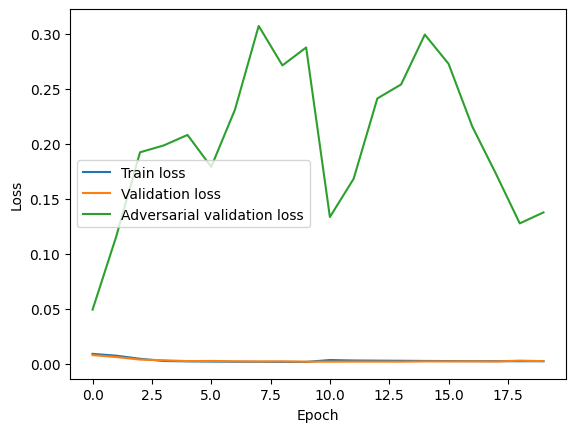

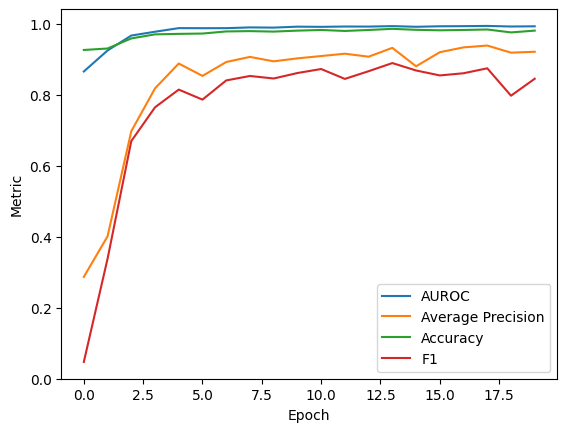

Max AP: 0.9382402162586398


In [35]:
# Load the metrics
metrics = torch.load(output_model_path + '/metrics.pth')
# Plot the training and validation loss
plt.figure()
plt.plot(metrics['train_loss'], label='Train loss')
plt.plot(metrics['valid_loss'], label='Validation loss')
plt.plot(metrics['adv_valid_loss'], label='Adversarial validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the AUROC, AP, accuracy and F1
plt.figure()
plt.plot(metrics['auroc'], label='AUROC')
plt.plot(metrics['ap'], label='Average Precision')
plt.plot(metrics['accuracy'], label='Accuracy')
plt.plot(metrics['f1'], label='F1')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()

# Print max AP 
max_ap = max(metrics['ap'])
print(f"Max AP: {max_ap}")

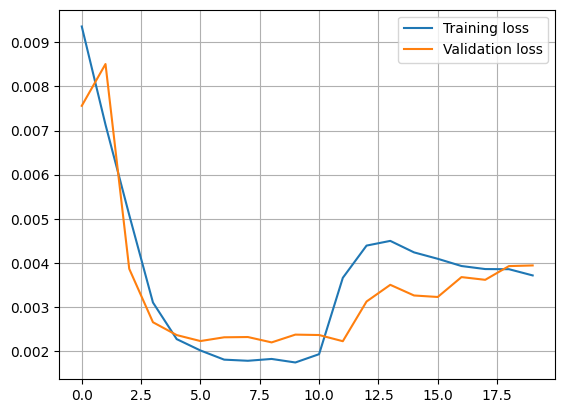

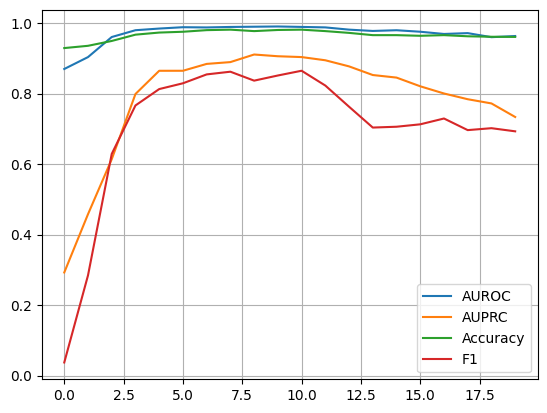

In [16]:
# plot training and validation loss
plt.figure()
plt.plot(train_loss_all, label='Training loss')
plt.plot(valid_loss_all, label='Validation loss')
plt.legend()
plt.grid()
plt.show()

# plot validation metrics
plt.figure()
plt.plot(auroc_all, label='AUROC')
plt.plot(ap_all, label='AUPRC')
plt.plot(accuracy_all, label='Accuracy')
plt.plot(f1_all, label='F1')
plt.legend()
plt.grid()
plt.show()